## Import Libraries and Define Functions

In [2]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import scipy
import skimage
import matplotlib.pyplot as plt

In [3]:
def create_placeholders(nx,ny):
    """
    Parameters:
        nx -- number of x features
        ny -- number of y features
    Returns:
        X -- tensorflow placeholder corresponding to inputs
        Y -- tensorflow placeholder corresponding to labels of input data
    """
    
    X = tf.placeholder(tf.float32, shape=(nx, None), name = 'X')
    Y = tf.placeholder(tf.float32, shape=(ny, None), name = 'Y')
    
    return X,Y

In [4]:
X,Y = create_placeholders(50,3)
print(X)
print(Y)

Tensor("X:0", shape=(50, ?), dtype=float32)
Tensor("Y:0", shape=(3, ?), dtype=float32)


In [5]:
def initialize_parameters(layer_dims):
    """
    Parameters:
        layer_dims -- list containing integer values corresponding to the dims of 
                      each layer [input_layer,l1,l2,...,y_layer], #layers := len(layer_dims)-1
    Returns:
        parameters -- python dictionary containing the Tensorflow variables corresponding to the weights
                      and biases of each layer
    """
    nl = len(layer_dims)
    parameters = {}
    
    for l in range(1,nl):
        parameters["W"+str(l)] = (tf.get_variable("W"+str(l), [layer_dims[l],layer_dims[l-1]], 
                                                      initializer = tf.contrib.layers.xavier_initializer(seed = 1)))
        parameters["b"+str(l)] = tf.get_variable("b"+str(l), [layer_dims[l],1], initializer = tf.zeros_initializer())
        
    return parameters

In [7]:
tf.reset_default_graph()
params = initialize_parameters([4,5,4,1])
print(params["W1"],params["b1"])
print(params["W2"],params["b2"])
print(len(params))

<tf.Variable 'W1:0' shape=(5, 4) dtype=float32_ref> <tf.Variable 'b1:0' shape=(5, 1) dtype=float32_ref>
<tf.Variable 'W2:0' shape=(4, 5) dtype=float32_ref> <tf.Variable 'b2:0' shape=(4, 1) dtype=float32_ref>
6


For now, the forward propagation function uses the relu function for each hidden layer. Leaky relu may be used later.

In [8]:
def forward_prop(X, parameters, layer_dims):
    """
    Parameters:
        X          -- tensor corresponding to input data
        parameters -- dictionary containing tensors corresponding to the weights and biases
        layer_dims -- list containing integer values corresponding to the dims of 
                      each layer [input_layer,l1,l2,...,y_layer], #layers := len(layer_dims)-1
    Returns:
        Z3 -- tensor corresponding to the output of the last layer before activation
    """
    nl = len(layer_dims)
    
    Z = tf.matmul(parameters['W1'],X) + parameters['b1']
    A = tf.nn.relu(Z)
    
    for l in range(2,nl-1):
        W = parameters['W'+str(l)]
        b = parameters['b'+str(l)]
        Z = tf.matmul(W,A) + b
        A = tf.nn.relu(Z)
    W = parameters['W'+str(nl-1)]
    b = parameters['b'+str(nl-1)]
    ZL = tf.matmul(W,A)+b
    
    return ZL

In [9]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 1)
    parameters = initialize_parameters([12288,5,4,1])
    ZL = forward_prop(X, parameters, [12288,5,4,1])
    print("ZL = " + str(ZL))

ZL = Tensor("add_2:0", shape=(1, ?), dtype=float32)


The sigmoid cross entropy loss function is used for this binary classification problem.

In [10]:
def calc_cost(ZL, Y):
    """
    Parameters:
        Z3 -- tensor corresponding to the output of the last layer before activation
        Y -- tensorflow placeholder corresponding to labels of input data
    Returns:
        cost -- tensor of the cost function
    """
    logits = tf.transpose(ZL)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=labels))
    
    return cost

In [11]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 1)
    parameters = initialize_parameters([12288,5,4,1])
    ZL = forward_prop(X, parameters, [12288,5,4,1])
    cost = calc_cost(ZL, Y)
    print(cost)

Tensor("Mean:0", shape=(), dtype=float32)


In [12]:
def random_mini_batch(X, Y, minibatch_size,seed=1):
    """
    Parameters:
        X -- numpy array of all input cases
        Y -- numpy array of labels of all input cases
        minibatch_size -- size of each minibatch
        seed -- np.random.seed(seed)
    Returns:
        minibatches --  list of mini-batches (X_minibatch,Y_minibatch)
    """
    
    np.random.seed(seed)
    
    num_minibatch = int(X.shape[1]/minibatch_size)
    
    idx = np.arange(0,X.shape[1],1)
    np.random.shuffle(idx)
    X = X[:,idx]
    Y = Y[:,idx]
    
    minibatches = []
    
    for minibatch in range(num_minibatch):
        
        X_minibatch = X[:,minibatch*minibatch_size:(minibatch+1)*minibatch_size]
        Y_minibatch = Y[:,minibatch*minibatch_size:(minibatch+1)*minibatch_size]
        minibatches.append((X_minibatch,Y_minibatch))
        
    return minibatches       
    
    

In [13]:
batch_x,batch_y = (np.random.randn(50,500),np.random.randn(1,500))
minibatches = random_mini_batch(batch_x,batch_y,50,10)
print(len(minibatches))

10


For now, a gradient descent optimization is used due to its better performance in initial training over Adam optimization. During hyperparater tuning this could be changed back to Adam or possibly include momentum or RMSprop.

In [14]:
def model(X_train, Y_train, X_test, Y_test, layer_dims, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 1000, print_cost = True, seed=3):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set
    Y_train -- test set
    X_test -- training set
    Y_test -- test set
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
        
    tf.reset_default_graph()
    tf.set_random_seed(1)
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    
    X, Y = create_placeholders(n_x,n_y)
    
    parameters = initialize_parameters(layer_dims)
    
    ZL = forward_prop(X, parameters, layer_dims)
    
    cost = calc_cost(ZL, Y)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):
            
            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batch(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X,Y:minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches
                
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
            # plot the cost
        plt.plot(np.squeeze(costs[1:]))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.cast(tf.greater(tf.sigmoid(ZL),.5),'float'), Y)

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters
                

    

In [15]:
def train_test_sets(X, Y, seed=1, test_size = .3):
    """
    Parameters:
        X -- numpy array input data
        Y -- numpy array label of input data
        seed -- np.random.seed(seed)
        test_size -- percentage of data that is test set
    Returns:
        X_train
        Y_train
        X_test
        Y_test
    """
    idx = np.arange(0,X.shape[1],1)
    np.random.shuffle(idx)
    X = X[:,idx]
    Y = Y[:,idx]
    
    train_num = int((1-test_size)*X.shape[1])
    
    X_train = X[:,0:train_num]
    Y_train = Y[:,0:train_num]
    X_test = X[:,train_num:]
    Y_test = Y[:,train_num:]
    
    return X_train,Y_train,X_test,Y_test

    

## Importing the Dataset and Preprocessing

In [16]:
data_root = os.path.expanduser('./cell_images/')
class_names = os.listdir(data_root)

In [17]:
data_root = pathlib.Path(data_root)
for item in data_root.iterdir():
  print(item)

cell_images/Uninfected
cell_images/Parasitized


In [18]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names.reverse()
label_names

['Uninfected', 'Parasitized']

In [19]:
image_data = []
image_labels = []
for label in range(len(label_names)):
    for file in os.listdir(data_root/label_names[label]):
        try:
            image = plt.imread(str(data_root/label_names[label]/file))
            image = skimage.transform.resize(image,(64,64,3))
            image_data.append(image)
            image_labels.append(label)
        except:
            pass

/opt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [20]:
image_data = np.array(image_data)
image_labels = np.array(image_labels)
image_labels = image_labels.reshape(image_labels.shape[0],1)
print(image_data.shape,image_labels.shape)

(27558, 64, 64, 3) (27558, 1)


In [21]:
np.random.seed(20)
idx1 = np.arange(0,27558,1)
np.random.shuffle(idx1)
image_shuffle = image_data[idx1]
labels_shuffle = image_labels[idx1]

In [22]:
image_data_flatten = image_shuffle.reshape(image_shuffle.shape[0],-1).T
image_labels_T = labels_shuffle.T
print(image_data_flatten.shape,image_labels_T.shape)

(12288, 27558) (1, 27558)


A sample size of 500 is used initially to speed up parameter tuning. Larger sample sizes will be used below.

In [23]:
idx2 = np.random.randint(0,image_data.shape[0],500)
X_data = image_data_flatten[:,idx2]
Y_data = image_labels_T[:,idx2]
print(X_data.shape,Y_data.shape)

(12288, 500) (1, 500)


In [24]:
X_train,Y_train,X_test,Y_test = train_test_sets(X_data,Y_data,seed=22)
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(12288, 350) (1, 350) (12288, 150) (1, 150)


## Hyperparameter Tuning
### Learning Rate
Learning rates ranging from .0001 to .1 are tested selecting rates randomly on a log base 10 scale.

Cost after epoch 0: 1.569654
Cost after epoch 100: 0.681706
Cost after epoch 200: 0.679305
Cost after epoch 300: 0.675457
Cost after epoch 400: 0.670119
Cost after epoch 500: 0.662186
Cost after epoch 600: 0.660731
Cost after epoch 700: 0.643326
Cost after epoch 800: 0.646398
Cost after epoch 900: 0.640061


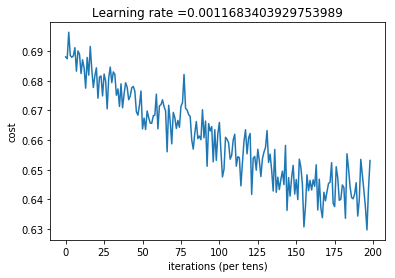

Parameters have been trained!
Train Accuracy: 0.69142854
Test Accuracy: 0.66
Cost after epoch 0: 1.569654
Cost after epoch 100: 0.692355
Cost after epoch 200: 0.691560
Cost after epoch 300: 0.692168
Cost after epoch 400: 0.689362
Cost after epoch 500: 0.690462
Cost after epoch 600: 0.690309
Cost after epoch 700: 0.691459
Cost after epoch 800: 0.689465
Cost after epoch 900: 0.691385


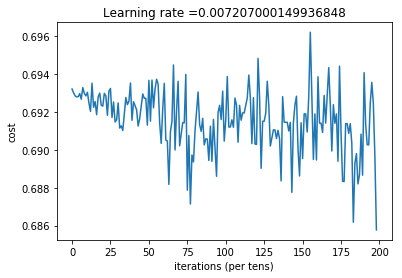

Parameters have been trained!
Train Accuracy: 0.5314286
Test Accuracy: 0.47333333
Cost after epoch 0: 1.569654
Cost after epoch 100: 0.682907
Cost after epoch 200: 0.680559
Cost after epoch 300: 0.677056
Cost after epoch 400: 0.671955
Cost after epoch 500: 0.665166
Cost after epoch 600: 0.663715
Cost after epoch 700: 0.647503
Cost after epoch 800: 0.650980
Cost after epoch 900: 0.645381


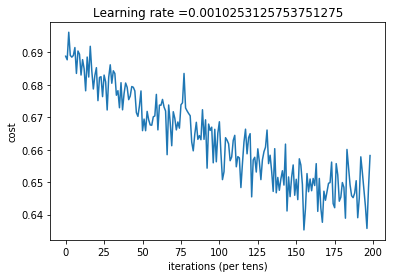

Parameters have been trained!
Train Accuracy: 0.67142856
Test Accuracy: 0.6533333
Cost after epoch 0: 1.569654
Cost after epoch 100: 0.691000
Cost after epoch 200: 0.689828
Cost after epoch 300: 0.691923
Cost after epoch 400: 0.686980
Cost after epoch 500: 0.689540
Cost after epoch 600: 0.689599
Cost after epoch 700: 0.691350
Cost after epoch 800: 0.688753
Cost after epoch 900: 0.691361


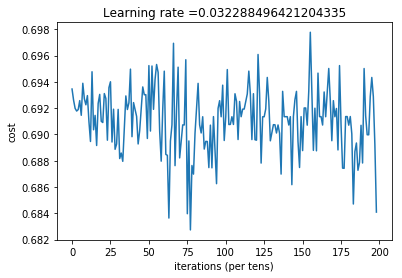

Parameters have been trained!
Train Accuracy: 0.5314286
Test Accuracy: 0.47333333
Cost after epoch 0: 1.569654
Cost after epoch 100: 0.694178
Cost after epoch 200: 0.685495
Cost after epoch 300: 0.683756
Cost after epoch 400: 0.676533
Cost after epoch 500: 0.683586
Cost after epoch 600: 0.681530
Cost after epoch 700: 0.667853
Cost after epoch 800: 0.676768
Cost after epoch 900: 0.671877


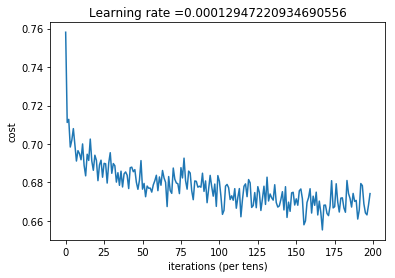

Parameters have been trained!
Train Accuracy: 0.6
Test Accuracy: 0.5933333
Cost after epoch 0: 1.569654
Cost after epoch 100: 0.692187
Cost after epoch 200: 0.691279
Cost after epoch 300: 0.692066
Cost after epoch 400: 0.688846
Cost after epoch 500: 0.690195
Cost after epoch 600: 0.690074
Cost after epoch 700: 0.691397
Cost after epoch 800: 0.689228
Cost after epoch 900: 0.691355


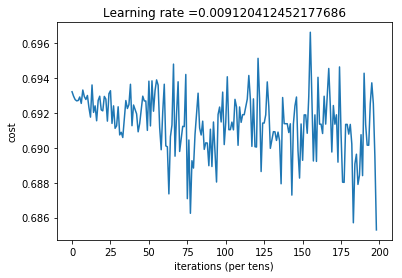

Parameters have been trained!
Train Accuracy: 0.5314286
Test Accuracy: 0.47333333
Cost after epoch 0: 1.569654
Cost after epoch 100: 0.698092
Cost after epoch 200: 0.687214
Cost after epoch 300: 0.685681
Cost after epoch 400: 0.678543
Cost after epoch 500: 0.685006
Cost after epoch 600: 0.683525
Cost after epoch 700: 0.670843
Cost after epoch 800: 0.680021
Cost after epoch 900: 0.674917


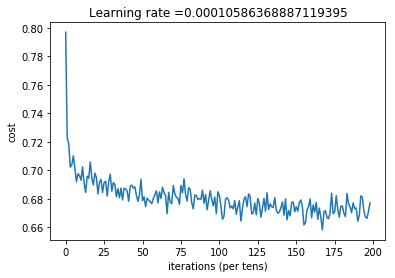

Parameters have been trained!
Train Accuracy: 0.5942857
Test Accuracy: 0.58666664
Cost after epoch 0: 1.569654
Cost after epoch 100: 0.691488
Cost after epoch 200: 0.690311
Cost after epoch 300: 0.691897
Cost after epoch 400: 0.687441
Cost after epoch 500: 0.689636
Cost after epoch 600: 0.689645
Cost after epoch 700: 0.691346
Cost after epoch 800: 0.688826
Cost after epoch 900: 0.691353


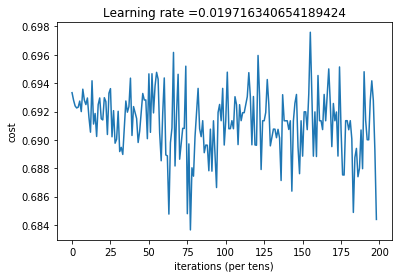

Parameters have been trained!
Train Accuracy: 0.5314286
Test Accuracy: 0.47333333
Cost after epoch 0: 1.569654
Cost after epoch 100: 0.678620
Cost after epoch 200: 0.675389
Cost after epoch 300: 0.669789
Cost after epoch 400: 0.662805
Cost after epoch 500: 0.651696
Cost after epoch 600: 0.649485
Cost after epoch 700: 0.627657
Cost after epoch 800: 0.630157
Cost after epoch 900: 0.620921


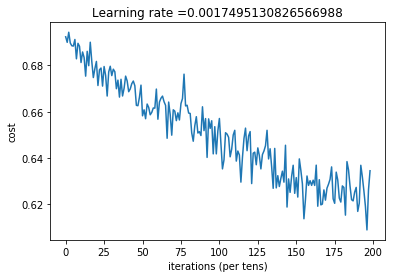

Parameters have been trained!
Train Accuracy: 0.7114286
Test Accuracy: 0.66
Cost after epoch 0: 1.569654
Cost after epoch 100: 0.692466
Cost after epoch 200: 0.691758
Cost after epoch 300: 0.692254
Cost after epoch 400: 0.689752
Cost after epoch 500: 0.690683
Cost after epoch 600: 0.690511
Cost after epoch 700: 0.691528
Cost after epoch 800: 0.689681
Cost after epoch 900: 0.691426


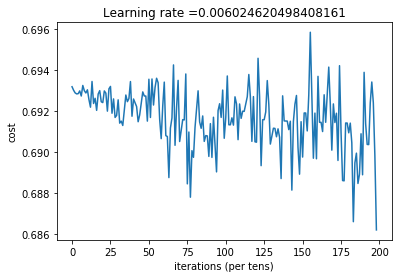

Parameters have been trained!
Train Accuracy: 0.5314286
Test Accuracy: 0.47333333


In [117]:
np.random.seed(30)
learning_rates = np.random.uniform(1,4,10)
learning_rates = np.power(10,-1*learning_rates)
for learning_rate in learning_rates:
    parameters = model(X_train,Y_train,X_test,Y_test,
                       layer_dims=[X_train.shape[0],4,1],
                       num_epochs=1000,
                       learning_rate=learning_rate,
                       minibatchsize = 200)

A learning rate of .001 is selected initially. As the number of hidden layers increases and the number of neurons in each layer are adjusted, this will likely need to be adjusted.

Now try the learning rate on a larger sample.

In [25]:
idx2 = np.random.randint(0,image_data.shape[0]-1,5000)
X_data = image_data_flatten[:,idx2]
Y_data = image_labels_T[:,idx2]
print(X_data.shape,Y_data.shape)

(12288, 5000) (1, 5000)


In [26]:
X_train,Y_train,X_test,Y_test = train_test_sets(X_data,Y_data,seed=22)
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(12288, 3500) (1, 3500) (12288, 1500) (1, 1500)


Cost after epoch 0: 0.729934
Cost after epoch 100: 0.649432
Cost after epoch 200: 0.627466
Cost after epoch 300: 0.608027
Cost after epoch 400: 0.591831
Cost after epoch 500: 0.577330
Cost after epoch 600: 0.561830
Cost after epoch 700: 0.547216
Cost after epoch 800: 0.535456
Cost after epoch 900: 0.521225


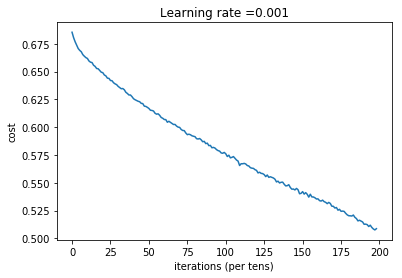

Parameters have been trained!
Train Accuracy: 0.7797143
Test Accuracy: 0.68733335


In [120]:
parameters = model(X_train,Y_train,X_test,Y_test,
                   layer_dims=[X_train.shape[0],4,1],
                   num_epochs=1000,
                   learning_rate=.001,
                   minibatch_size=200)

In [41]:
image_data_low_res = []
for image in image_data:
    image = skimage.transform.resize(image,(32,32,3))
    image_data_low_res.append(image)

/opt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [42]:
image_data_low_res = np.array(image_data_low_res)
print(image_data_low_res.shape,image_labels.shape)

(27558, 32, 32, 3) (27558, 1)


In [43]:
image_shuffle = image_data_low_res[idx1]
labels_shuffle = image_labels[idx1]

In [44]:
image_data_flatten = image_shuffle.reshape(image_shuffle.shape[0],-1).T
image_labels_T = labels_shuffle.T
print(image_data_flatten.shape,image_labels_T.shape)

(3072, 27558) (1, 27558)


In [45]:
X_data = image_data_flatten[:,idx2]
Y_data = image_labels_T[:,idx2]
print(X_data.shape,Y_data.shape)

(3072, 5000) (1, 5000)


In [46]:
X_train,Y_train,X_test,Y_test = train_test_sets(X_data,Y_data,seed=22)
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(3072, 3500) (1, 3500) (3072, 1500) (1, 1500)


Cost after epoch 0: 0.703244
Cost after epoch 100: 0.638693
Cost after epoch 200: 0.614707
Cost after epoch 300: 0.599413
Cost after epoch 400: 0.586510
Cost after epoch 500: 0.576809
Cost after epoch 600: 0.566554
Cost after epoch 700: 0.554252
Cost after epoch 800: 0.544679
Cost after epoch 900: 0.539913
Cost after epoch 1000: 0.529974
Cost after epoch 1100: 0.524138
Cost after epoch 1200: 0.514873
Cost after epoch 1300: 0.509410
Cost after epoch 1400: 0.499062
Cost after epoch 1500: 0.489673
Cost after epoch 1600: 0.483265
Cost after epoch 1700: 0.473390
Cost after epoch 1800: 0.463926
Cost after epoch 1900: 0.454687
Cost after epoch 2000: 0.442075
Cost after epoch 2100: 0.440087
Cost after epoch 2200: 0.427616
Cost after epoch 2300: 0.419900
Cost after epoch 2400: 0.409750
Cost after epoch 2500: 0.410083
Cost after epoch 2600: 0.396557
Cost after epoch 2700: 0.387716
Cost after epoch 2800: 0.377639
Cost after epoch 2900: 0.365339
Cost after epoch 3000: 0.367300
Cost after epoch 310

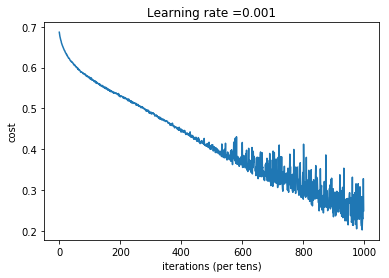

Parameters have been trained!
Train Accuracy: 0.9268571
Test Accuracy: 0.69733334


In [49]:
parameters = model(X_train,Y_train,X_test,Y_test,
                   layer_dims=[X_train.shape[0],30,30,1],
                   num_epochs=5000,
                   learning_rate=.001,
                   minibatch_size=200)

In [50]:
idx2 = np.random.randint(0,image_data_low_res.shape[0]-1,20000)
X_data = image_data_flatten[:,idx2]
Y_data = image_labels_T[:,idx2]
print(X_data.shape,Y_data.shape)

(3072, 20000) (1, 20000)


In [51]:
X_train,Y_train,X_test,Y_test = train_test_sets(X_data,Y_data,seed=22)
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(3072, 14000) (1, 14000) (3072, 6000) (1, 6000)


Cost after epoch 0: 0.703498
Cost after epoch 100: 0.689196
Cost after epoch 200: 0.685204
Cost after epoch 300: 0.683809
Cost after epoch 400: 0.681334
Cost after epoch 500: 0.679369
Cost after epoch 600: 0.676216
Cost after epoch 700: 0.673291
Cost after epoch 800: 0.670794
Cost after epoch 900: 0.668033
Cost after epoch 1000: 0.665031
Cost after epoch 1100: 0.662479
Cost after epoch 1200: 0.659692
Cost after epoch 1300: 0.656093
Cost after epoch 1400: 0.654026
Cost after epoch 1500: 0.652177
Cost after epoch 1600: 0.648465
Cost after epoch 1700: 0.647105
Cost after epoch 1800: 0.646338
Cost after epoch 1900: 0.643881
Cost after epoch 2000: 0.639645
Cost after epoch 2100: 0.634703
Cost after epoch 2200: 0.633821
Cost after epoch 2300: 0.635704
Cost after epoch 2400: 0.631771
Cost after epoch 2500: 0.631755
Cost after epoch 2600: 0.628017
Cost after epoch 2700: 0.622797
Cost after epoch 2800: 0.626113
Cost after epoch 2900: 0.620973


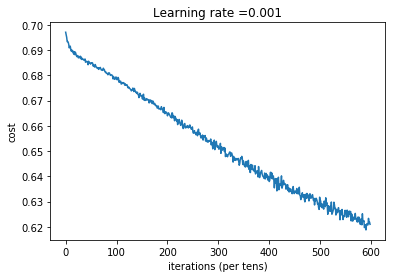

Parameters have been trained!
Train Accuracy: 0.65935713
Test Accuracy: 0.64883333


In [53]:
parameters = model(X_train,Y_train,X_test,Y_test,
                   layer_dims=[X_train.shape[0],10,10,1],
                   num_epochs=3000,
                   learning_rate=.001,
                   minibatch_size=5000)

In [44]:
def predict(X, parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    Z1 = np.dot(W1,X) + b1
    A1 = np.max(Z1,0)
    Z2 = np.dot(W2,A1) + b2
    A2 = 1/(1+np.exp(Z2))
    
    pred = np.less(A2,.5)
        
    return pred
    
    
    

In [45]:
for i in range(20):
    print(predict(X_train[:,i],parameters),Y_train[:,i])


[[0.14124386]]
[[ True]] [1]
[[0.16829243]]
[[ True]] [0]
[[0.24953987]]
[[ True]] [0]
[[0.13847541]]
[[ True]] [0]
[[0.21184584]]
[[ True]] [0]
[[0.14265398]]
[[ True]] [1]
[[0.28553505]]
[[ True]] [1]
[[0.08798666]]
[[ True]] [1]
[[0.06546625]]
[[ True]] [0]
[[0.09973013]]
[[ True]] [1]
[[0.11462214]]
[[ True]] [1]
[[0.22913569]]
[[ True]] [0]
[[0.17827219]]
[[ True]] [1]
[[0.18470334]]
[[ True]] [0]
[[0.14029962]]
[[ True]] [1]
[[0.30556789]]
[[ True]] [0]
[[0.09184079]]
[[ True]] [0]
[[0.3113429]]
[[ True]] [1]
[[0.12737556]]
[[ True]] [0]
[[0.11461152]]
[[ True]] [1]
